In [1]:
import gc
import os
from itertools import islice

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
from transformers import pipeline, CLIPModel, CLIPProcessor
from tqdm import tqdm

# Configuration
LOADER_PATCH_SIZE = 32
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Cuda Availability:{torch.cuda.is_available()} Training on {device}")

Cuda Availability:True Training on cuda


# Notebook for interactive testing for CLIP

In [2]:

class Cfg:
    model_id: str = "openai/clip-vit-base-patch32"
    batch_size: int = 32
    epochs: int = 40
    seed:   int = 42

    lr_head: float = 1e-3
    wd_head: float = 1e-4
    lr_lora: float = 1e-4
    wd_lora: float = 1e-2
    lambda_text: float = 0.3

    early_stopping: bool = True
    early_stop_patience = 3
    early_stop_minimum_improvement:float = 0.02


    lora_rank: int = 8
    lora_alpha: int = 16
    lora_dropout: float = 0.0
    lora_target: tuple = ("q_proj","k_proj","v_proj","out_proj") 

    amp: bool = True

cfg = Cfg()

PREPROCESS_DATA_ROOT = "data/preprocessed"
torch.manual_seed(cfg.seed)
model_id = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(model_id).to(device).eval()
processor  = CLIPProcessor.from_pretrained(model_id)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [3]:
def collate_pil(batch):
    images, labels = zip(*batch)
    return list(images), torch.tensor(labels)

def preprocess_dataset(split="train",data_root='data',outputdir="data/preprocessed",batchsize=cfg.batch_size,fp16=False):
    os.makedirs(outputdir,exist_ok=True)
    dataset = datasets.Flowers102(root=data_root, split=split, download=True)
    classes = dataset.classes
    loader = DataLoader(dataset, batch_size=batchsize, shuffle= True if split=="train" else False, num_workers=0,collate_fn=collate_pil)

    N = len(dataset)
    C, H, W = 3, 224, 224
    pixels = torch.empty((N,C,H,W), dtype=torch.float32 if not fp16 else torch.float16)
    labels = torch.empty(N, dtype=torch.long)

    print(f"Preprocessing {split} data...")

    index = 0
    with torch.no_grad():
        for images, y in tqdm(loader,desc=f"Preprocessing {split}"):
            pix = processor(images=images,return_tensors="pt")['pixel_values']
            if fp16:
                pix = pix.half()
            b = pix.size(0) 
            pixels[index:index+b] = pix
            labels[index:index+b] = y
            index += b


    out_path = os.path.join(outputdir, f"{split}.pt")
    torch.save({"pixel_values": pixels, "labels": labels, "fp16": fp16,"classes":classes}, out_path)
    print(f"Saved → {out_path} (pixels: {pixels.shape}, dtype={pixels.dtype})")

    print("Performing Garbage Cleaning...")
    del pixels, labels
    torch.cuda.empty_cache()
    gc.collect()

    %reset_selective -f pixels
    %reset_selective -f labels

class CacheDataset:
    def __init__(self, split="train", root="data/preprocessed"):
        path = os.path.join(root, f"{split}.pt")
        obj = torch.load(path, map_location="cpu")
        self.pixel_values = obj["pixel_values"]
        self.labels = obj["labels"]
        self.fp16 = bool(obj.get("fp16", False))
        self.classes = obj['classes']

    def __len__(self):
        return self.labels.numel()

    def __getitem__(self, idx):
        return self.pixel_values[idx], self.labels[idx]


if not os.path.exists(os.path.join(PREPROCESS_DATA_ROOT, "train.pt")):
    preprocess_dataset(split="train",data_root="data",outputdir=PREPROCESS_DATA_ROOT,fp16=False)
if not os.path.exists(os.path.join(PREPROCESS_DATA_ROOT, "val.pt")):
    preprocess_dataset(split="val",data_root="data",outputdir=PREPROCESS_DATA_ROOT,fp16=False)
if not os.path.exists(os.path.join(PREPROCESS_DATA_ROOT, "test.pt")):
    preprocess_dataset(split="test",data_root="data",outputdir=PREPROCESS_DATA_ROOT,fp16=False)

train_set = CacheDataset(split="train")
val_set = CacheDataset(split="val")
test_set = CacheDataset(split="test")

classname = val_set.classes
classname




100%|██████████| 345M/345M [00:13<00:00, 26.3MB/s]
100%|██████████| 502/502 [00:00<00:00, 2.39MB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 34.9MB/s]


Preprocessing train data...


Preprocessing train: 100%|██████████| 32/32 [00:09<00:00,  3.35it/s]


Saved → data/preprocessed/train.pt (pixels: torch.Size([1020, 3, 224, 224]), dtype=torch.float32)
Performing Garbage Cleaning...
Preprocessing val data...


Preprocessing val: 100%|██████████| 32/32 [00:09<00:00,  3.40it/s]


Saved → data/preprocessed/val.pt (pixels: torch.Size([1020, 3, 224, 224]), dtype=torch.float32)
Performing Garbage Cleaning...
Preprocessing test data...


Preprocessing test: 100%|██████████| 193/193 [01:14<00:00,  2.59it/s]


Saved → data/preprocessed/test.pt (pixels: torch.Size([6149, 3, 224, 224]), dtype=torch.float32)
Performing Garbage Cleaning...


['pink primrose',
 'hard-leaved pocket orchid',
 'canterbury bells',
 'sweet pea',
 'english marigold',
 'tiger lily',
 'moon orchid',
 'bird of paradise',
 'monkshood',
 'globe thistle',
 'snapdragon',
 "colt's foot",
 'king protea',
 'spear thistle',
 'yellow iris',
 'globe-flower',
 'purple coneflower',
 'peruvian lily',
 'balloon flower',
 'giant white arum lily',
 'fire lily',
 'pincushion flower',
 'fritillary',
 'red ginger',
 'grape hyacinth',
 'corn poppy',
 'prince of wales feathers',
 'stemless gentian',
 'artichoke',
 'sweet william',
 'carnation',
 'garden phlox',
 'love in the mist',
 'mexican aster',
 'alpine sea holly',
 'ruby-lipped cattleya',
 'cape flower',
 'great masterwort',
 'siam tulip',
 'lenten rose',
 'barbeton daisy',
 'daffodil',
 'sword lily',
 'poinsettia',
 'bolero deep blue',
 'wallflower',
 'marigold',
 'buttercup',
 'oxeye daisy',
 'common dandelion',
 'petunia',
 'wild pansy',
 'primula',
 'sunflower',
 'pelargonium',
 'bishop of llandaff',
 'gaura',

In [4]:
train_loader = DataLoader(
    train_set, batch_size=cfg.batch_size, shuffle=True,
    num_workers=0, pin_memory=True
)
val_loader = DataLoader(
    val_set, batch_size=cfg.batch_size, shuffle=False,
    num_workers=0, pin_memory=True
)
test_loader = DataLoader(
    test_set, batch_size=cfg.batch_size, shuffle=False,
    num_workers=0, pin_memory=True
)

---
## Model Setting and Training

In [5]:
import torch
from tqdm import tqdm

promptTemplate = {
    "A photo of {}.",
    "A photo of flower {}.",
    "Botanic picture of {}",
    "A example picture of type {}"
}

@torch.no_grad()
def build_text_embeddings(names):
    embs = []
    for name in tqdm(names, desc="TextEmbed"):
        prompts = [t.format(name.replace("_"," ")) for t in promptTemplate]
        inputs = processor(text=prompts, return_tensors="pt", padding=True).to(device)
        te = clip_model.get_text_features(**inputs) 
        te = te / te.norm(dim=-1, keepdim=True)
        embs.append(te.mean(dim=0)) 
    text = torch.stack(embs, dim=0)    
    return text / text.norm(dim=-1, keepdim=True)

text_embs = build_text_embeddings(classname) 



TextEmbed: 100%|██████████| 102/102 [00:01<00:00, 63.25it/s]


----
## Building CLIP model with LoRA and word embedding.

Have to implement a LoRA linear layer ourselves.

In [6]:
import torch, torch.nn as nn
from transformers.models.clip.modeling_clip import CLIPVisionModel


class LoRALinearLayer(nn.Module):
    def __init__(self, base: nn.Linear, r=8, alpha=16, dropout=0.0):

        super().__init__()
        self.base = base 
        self.r = r
        self.scaling = alpha / r
        dev = base.weight.device
        dt  = base.weight.dtype



        if r > 0:
            self.lora_A = nn.Linear(base.in_features, r, bias=False).to(dev, dtype=dt)
            self.lora_B = nn.Linear(r, base.out_features, bias=False).to(dev, dtype=dt)
            self.dropout = nn.Dropout(dropout)
            nn.init.kaiming_uniform_(self.lora_A.weight,a=5**0.5)
            nn.init.zeros_(self.lora_B.weight) 
        else:
            self.lora_A = None
            self.lora_B = None
            self.dropout = nn.Identity()

        for p in self.base.parameters():
            p.requires_grad = False

    def forward(self, x):
        if self.r > 0:
            return self.base(x) + self.dropout(self.lora_B(self.lora_A(x))) * self.scaling
        else:
            return self.base(x)



def lora_injection(clip_model: nn.Module, target_names=("q_proj","k_proj","v_proj","out_proj")):
    """
    """
    assert isinstance(clip_model.vision_model, CLIPVisionModel.__mro__[0].__class__) or hasattr(clip_model, "vision_model")
    lora_params = []
    for name, module in clip_model.vision_model.named_modules():
        for t in target_names:
            if hasattr(module, t):
                lin = getattr(module, t)
                if isinstance(lin, nn.Linear):
                    lora_lin = LoRALinearLayer(lin, r=cfg.lora_rank, alpha=cfg.lora_alpha, dropout=cfg.lora_dropout)
                    setattr(module, t, lora_lin)
                    lora_params += list(lora_lin.lora_A.parameters()) + list(lora_lin.lora_B.parameters())
    for p in clip_model.vision_model.parameters():
        p.requires_grad = False
    for p in lora_params:
        p.requires_grad = True
    return lora_params

def build_head_and_optim(clip_model: CLIPModel):
    feat_dim = clip_model.config.projection_dim  
    head = nn.Linear(feat_dim, 102).to(device)

    lora_params = lora_injection(clip_model, target_names=cfg.lora_target)
    clip_model.to(device)

    optim = torch.optim.AdamW(
        [
            {"params": head.parameters(),      "lr": cfg.lr_head, "weight_decay": cfg.wd_head},
            {"params": lora_params,            "lr": cfg.lr_lora, "weight_decay": cfg.wd_lora},
        ]
    )
    scaler = torch.amp.GradScaler(enabled=(device=="cuda" and cfg.amp))
    return head, optim, scaler


In [7]:
head, optimizer, scaler = build_head_and_optim(clip_model)
ce = torch.nn.CrossEntropyLoss()

def get_image_feats(images):
    if isinstance(images, torch.Tensor):
        pixel_values = images.to(device, dtype=torch.float16 if (device=="cuda" and cfg.amp) else torch.float32)
    else:
        inputs = processor(images=images, return_tensors="pt").to(device)
        pixel_values = inputs["pixel_values"]

    feats = clip_model.get_image_features(pixel_values=pixel_values)  
    feats = feats / feats.norm(dim=-1, keepdim=True)
    return feats

def supervised_logits(feats):
    return head(feats)  

def text_logits(feats):
    return (feats @ text_embs.T) * clip_model.logit_scale.exp()


----
## Main Training Epoch

In [8]:
class EarlyStopper:
    def __init__(self):
        self.counter = 0
        self.last_loss = 0
        self.patience = cfg.early_stop_patience
        self.enable = cfg.early_stopping
        self.delta = cfg.early_stop_minimum_improvement
    def report(self,loss):
        if self.last_loss - loss < self.delta:
            self.counter += 1
        else:
            self.counter = 0
        self.last_loss = loss

    def stop_flag(self):
        return self.enable and (self.counter >= self.patience)

def run_epoch(loader: DataLoader, train: bool=True):
    if train:
        head.train()
        clip_model.train()
    else:
        head.eval()
        clip_model.eval()

    total, correct_cls, correct_txt = 0, 0, 0
    loss_sum = 0.0
    for images, labels in tqdm(loader, desc="Train" if train else "Eval"):
        labels = labels.to(device)
        with torch.amp.autocast(device_type=device,enabled=(device=="cuda" and cfg.amp)):
            feats = get_image_feats(images)                   

            logits_cls = supervised_logits(feats) 
            loss_cls = ce(logits_cls, labels)

            logits_txt = text_logits(feats) 
            loss_txt = ce(logits_txt, labels)

            loss = loss_cls + cfg.lambda_text * loss_txt 


        if train:
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        loss_sum += loss.item() * labels.size(0)
        total += labels.size(0)
        correct_cls += (logits_cls.argmax(dim=-1) == labels).sum().item()
        correct_txt += (logits_txt.argmax(dim=-1) == labels).sum().item()

    loss_avg = loss_sum / total

    return {
    "loss": loss_avg,
    "acc_cls": correct_cls/total,   
    "acc_txt": correct_txt/total,   
}



In [18]:
best_val = -1.0
best_head = None
earlystop = EarlyStopper()
for ep in range(1,cfg.epochs+1):
    training = run_epoch(train_loader, train=True)
    val = run_epoch(val_loader, train=False)
    print(f"[{ep}/{cfg.epochs}] "
          f"Train: loss={training['loss']:.4f} acc_cls={training['acc_cls']:.4f} acc_txt={training['acc_txt']:.4f} | "
          f"Val:   loss={val['loss']:.4f} acc_cls={val['acc_cls']:.4f} acc_txt={val['acc_txt']:.4f}")


    if val["acc_cls"] > best_val:
        best_val = val["acc_cls"]
        best_head = { k: v.detach().cpu() for k, v in head.state_dict().items() } 
    if earlystop.stop_flag():
        print(f"Early stop triggered...Exiting on epoch {ep}")

if best_head is not None:
    head.load_state_dict({k: v.to(device) for k, v in best_head.items()})
te = run_epoch(test_loader, train=False)
print(f"Test: loss={te['loss']:.4f}  acc_cls={te['acc_cls']:.4f}  acc_txt={te['acc_txt']:.4f}")


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.81it/s]


[1/40] Train: loss=5.0605 acc_cls=0.0382 acc_txt=0.6578 | Val:   loss=4.9554 acc_cls=0.1725 acc_txt=0.7020


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.70it/s]


[2/40] Train: loss=4.8601 acc_cls=0.3578 acc_txt=0.7225 | Val:   loss=4.7804 acc_cls=0.5245 acc_txt=0.7461


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.62it/s]


[3/40] Train: loss=4.6129 acc_cls=0.7490 acc_txt=0.8078 | Val:   loss=4.5712 acc_cls=0.7990 acc_txt=0.7912


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.75it/s]


[4/40] Train: loss=4.3281 acc_cls=0.9137 acc_txt=0.8873 | Val:   loss=4.3523 acc_cls=0.8686 acc_txt=0.8049


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.70it/s]


[5/40] Train: loss=4.0508 acc_cls=0.9549 acc_txt=0.9529 | Val:   loss=4.1288 acc_cls=0.8735 acc_txt=0.8137


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.72it/s]


[6/40] Train: loss=3.7849 acc_cls=0.9667 acc_txt=0.9755 | Val:   loss=3.9163 acc_cls=0.8814 acc_txt=0.8186


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.81it/s]


[7/40] Train: loss=3.5335 acc_cls=0.9784 acc_txt=0.9863 | Val:   loss=3.7264 acc_cls=0.8971 acc_txt=0.8069


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.57it/s]


[8/40] Train: loss=3.3036 acc_cls=0.9843 acc_txt=0.9902 | Val:   loss=3.5309 acc_cls=0.8980 acc_txt=0.8098


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.71it/s]


[9/40] Train: loss=3.0815 acc_cls=0.9912 acc_txt=0.9941 | Val:   loss=3.3423 acc_cls=0.9059 acc_txt=0.8118


Eval: 100%|██████████| 32/32 [00:01<00:00, 23.26it/s]


[10/40] Train: loss=2.8729 acc_cls=0.9902 acc_txt=0.9971 | Val:   loss=3.1774 acc_cls=0.9029 acc_txt=0.8010


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.55it/s]


[11/40] Train: loss=2.6698 acc_cls=0.9912 acc_txt=0.9971 | Val:   loss=3.0121 acc_cls=0.9049 acc_txt=0.8078


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.72it/s]


[12/40] Train: loss=2.4755 acc_cls=0.9951 acc_txt=0.9990 | Val:   loss=2.8765 acc_cls=0.9039 acc_txt=0.8010


Eval: 100%|██████████| 32/32 [00:01<00:00, 21.98it/s]


[13/40] Train: loss=2.2855 acc_cls=0.9961 acc_txt=0.9990 | Val:   loss=2.7142 acc_cls=0.9039 acc_txt=0.8039


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.83it/s]


[14/40] Train: loss=2.1024 acc_cls=0.9980 acc_txt=0.9980 | Val:   loss=2.5678 acc_cls=0.9029 acc_txt=0.8167


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.68it/s]


[15/40] Train: loss=1.9284 acc_cls=0.9980 acc_txt=1.0000 | Val:   loss=2.4732 acc_cls=0.9020 acc_txt=0.7951


Eval: 100%|██████████| 32/32 [00:01<00:00, 21.57it/s]


[16/40] Train: loss=1.7602 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=2.3323 acc_cls=0.9108 acc_txt=0.7961


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.81it/s]


[17/40] Train: loss=1.6019 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=2.2160 acc_cls=0.9127 acc_txt=0.7941


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.89it/s]


[18/40] Train: loss=1.4521 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=2.1094 acc_cls=0.9147 acc_txt=0.7990


Eval: 100%|██████████| 32/32 [00:01<00:00, 22.23it/s]


[19/40] Train: loss=1.3131 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=2.0085 acc_cls=0.9216 acc_txt=0.7882


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.78it/s]


[20/40] Train: loss=1.1826 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.9215 acc_cls=0.9206 acc_txt=0.7824


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.88it/s]


[21/40] Train: loss=1.0635 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.8568 acc_cls=0.9186 acc_txt=0.7735


Eval: 100%|██████████| 32/32 [00:01<00:00, 22.96it/s]


[22/40] Train: loss=0.9548 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.7731 acc_cls=0.9167 acc_txt=0.7784


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.88it/s]


[23/40] Train: loss=0.8566 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.6872 acc_cls=0.9216 acc_txt=0.7814


Eval: 100%|██████████| 32/32 [00:01<00:00, 25.01it/s]


[24/40] Train: loss=0.7682 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.6450 acc_cls=0.9167 acc_txt=0.7794


Eval: 100%|██████████| 32/32 [00:01<00:00, 23.98it/s]


[25/40] Train: loss=0.6896 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.5718 acc_cls=0.9167 acc_txt=0.7804


Eval: 100%|██████████| 32/32 [00:01<00:00, 25.04it/s]


[26/40] Train: loss=0.6183 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.5337 acc_cls=0.9206 acc_txt=0.7755


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.49it/s]


[27/40] Train: loss=0.5565 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.4720 acc_cls=0.9167 acc_txt=0.7784


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.89it/s]


[28/40] Train: loss=0.5016 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.4431 acc_cls=0.9147 acc_txt=0.7706


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.81it/s]


[29/40] Train: loss=0.4526 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.3796 acc_cls=0.9196 acc_txt=0.7775


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.64it/s]


[30/40] Train: loss=0.4101 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.3579 acc_cls=0.9176 acc_txt=0.7745


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.90it/s]


[31/40] Train: loss=0.3726 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.3358 acc_cls=0.9147 acc_txt=0.7696


Eval: 100%|██████████| 32/32 [00:01<00:00, 23.65it/s]


[32/40] Train: loss=0.3399 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.2977 acc_cls=0.9167 acc_txt=0.7824


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.66it/s]


[33/40] Train: loss=0.3100 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.2747 acc_cls=0.9167 acc_txt=0.7725


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.75it/s]


[34/40] Train: loss=0.2837 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.2430 acc_cls=0.9088 acc_txt=0.7804


Eval: 100%|██████████| 32/32 [00:01<00:00, 22.05it/s]


[35/40] Train: loss=0.2603 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.2159 acc_cls=0.9167 acc_txt=0.7794


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.56it/s]


[36/40] Train: loss=0.2400 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.2096 acc_cls=0.9137 acc_txt=0.7755


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.94it/s]


[37/40] Train: loss=0.2215 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.1870 acc_cls=0.9118 acc_txt=0.7824


Eval: 100%|██████████| 32/32 [00:01<00:00, 22.00it/s]


[38/40] Train: loss=0.2055 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.1708 acc_cls=0.9118 acc_txt=0.7794


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.72it/s]


[39/40] Train: loss=0.1908 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.1614 acc_cls=0.9078 acc_txt=0.7686


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.64it/s]


[40/40] Train: loss=0.1775 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.1484 acc_cls=0.9088 acc_txt=0.7735
Early stop triggered...Exiting on epoch 40


Eval: 100%|██████████| 193/193 [00:08<00:00, 23.68it/s]

Test: loss=2.0857  acc_cls=0.9045  acc_txt=0.7774


## Save trained model
### Save head layer and LoRA layers only

In [19]:
def save_light_model(path,clip_model,head):
    lora_states = {k:v for k,v in clip_model.state_dict().items() if "lora_" in k}
    checkpoint = {
        "clip_name": "openai/clip-vit-base-patch32",
        "num_of_classes": head.out_features,
        "head_state_dict": head.state_dict(),
        "lora_states": lora_states,
    }
    torch.save(checkpoint,path)
    print(f"Light weight model (only contains head and LoRA) saved to {path}")


def load_light_simple(path, device=device, lora_targets=("q_proj","k_proj","v_proj","out_proj")):
    checkpoint = torch.load(path, map_location=device)
    clip_model = CLIPModel.from_pretrained(checkpoint["clip_name"]).to(device)

    lora_injection(clip_model, target_names=lora_targets)
    missing, unexpected = clip_model.load_state_dict(checkpoint["lora_states"], strict=False) 
    print(missing, unexpected)

    feat_dim = clip_model.config.projection_dim
    head = nn.Linear(feat_dim,checkpoint["num_of_classes"]).to(device)
    head.load_state_dict(checkpoint["head_state_dict"])

    print(f"[light] loaded ← {path}")
    return clip_model, head



from pathlib import Path




def save_full_dir(output_dir, clip_model, head):
    output = Path(output_dir)
    output.mkdir(parents=True, exist_ok=True)
    clip_model.save_pretrained(output)  
    torch.save({"num_classes": head.out_features,
                "state_dict": head.state_dict()}, output/"head.pt")
    print(f"[full-dir] saved → {output}")

def load_full_dir(output_dir, device=device, lora_targets=("q_proj","k_proj","v_proj","out_proj")):
    from transformers import CLIPModel
    output = Path(output_dir)

    clip_model = CLIPModel.from_pretrained(output).to(device)  

    head_ckpt = torch.load(output/"head.pt", map_location=device)
    import torch.nn as nn
    head = nn.Linear(clip_model.config.projection_dim, head_ckpt["num_classes"]).to(device)
    head.load_state_dict(head_ckpt["state_dict"])
    print(f"[full-dir] loaded ← {output}")
    return clip_model, head


def save_full_model(path,clip_model,head):
    checkpoint = {
        "clip_name": "openai/clip-vit-base-patch32",
        "num_of_classes": head.out_features,
        "clip_state_dict": clip_model.state_dict(),
        "head_state_dict": head.state_dict(),
    }
    torch.save(checkpoint,path)
    print(f"Full  model  saved to {path}")

def load_full_model(path,device=device, lora_targets=("q_proj","k_proj","v_proj","out_proj")):
    checkpoint = torch.load(path, map_location=device)

    print(checkpoint["clip_name"])
    clip_model = CLIPModel.from_pretrained(checkpoint["clip_name"]).to(device)

    lora_injection(clip_model, target_names=lora_targets)
    clip_model.load_state_dict(checkpoint["clip_state_dict"], strict=True) 
    head = nn.Linear(clip_model.config.projection_dim,checkpoint["num_of_classes"]).to(device)
    head.load_state_dict(checkpoint["head_state_dict"])

    print(f"Full  model  loaded from {path}")
    return clip_model, head


In [20]:
os.makedirs("model",exist_ok=True)
save_light_model("model/clip_weights.pt", clip_model, head)

Light weight model (only contains head and LoRA) saved to model/clip_weights.pt


In [21]:
clip_model, head = load_light_simple("model/clip_weights.pt")

from itertools import islice
clip_model.eval()
head.eval()
processor = CLIPProcessor.from_pretrained(getattr(clip_model, "name_or_path", "openai/clip-vit-base-patch32"))

def collate_pil(batch):
    imgs, labels = zip(*batch)
    return list(imgs), torch.tensor(labels, dtype=torch.long)

val_set  = datasets.Flowers102(root="./data", split="val",  download=True)
test_set = datasets.Flowers102(root="./data", split="test", download=True)
val_loader  = DataLoader(val_set,  batch_size=64, shuffle=False, num_workers=0, collate_fn=collate_pil)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=0, collate_fn=collate_pil)

@torch.no_grad()
def evaluate_first(loader):
    total, correct = 0, 0
    for images, labels in loader:
        labels = labels.to(device)
        inputs = processor(images=images, return_tensors="pt").to(device)
        feats = clip_model.get_image_features(**inputs)       
        feats = feats / feats.norm(dim=-1, keepdim=True)
        logits = head(feats)                                   
        pred = logits.argmax(dim=-1)
        correct += (pred == labels).sum().item()
        total   += labels.size(0)
    return correct / total


val_acc  = evaluate_first(val_loader)
test_acc = evaluate_first(test_loader)
print(f"Val Acc = {val_acc:.4f} | Test Acc = {test_acc:.4f}")

['logit_scale', 'text_model.embeddings.token_embedding.weight', 'text_model.embeddings.position_embedding.weight', 'text_model.encoder.layers.0.self_attn.k_proj.weight', 'text_model.encoder.layers.0.self_attn.k_proj.bias', 'text_model.encoder.layers.0.self_attn.v_proj.weight', 'text_model.encoder.layers.0.self_attn.v_proj.bias', 'text_model.encoder.layers.0.self_attn.q_proj.weight', 'text_model.encoder.layers.0.self_attn.q_proj.bias', 'text_model.encoder.layers.0.self_attn.out_proj.weight', 'text_model.encoder.layers.0.self_attn.out_proj.bias', 'text_model.encoder.layers.0.layer_norm1.weight', 'text_model.encoder.layers.0.layer_norm1.bias', 'text_model.encoder.layers.0.mlp.fc1.weight', 'text_model.encoder.layers.0.mlp.fc1.bias', 'text_model.encoder.layers.0.mlp.fc2.weight', 'text_model.encoder.layers.0.mlp.fc2.bias', 'text_model.encoder.layers.0.layer_norm2.weight', 'text_model.encoder.layers.0.layer_norm2.bias', 'text_model.encoder.layers.1.self_attn.k_proj.weight', 'text_model.encode

In [ ]:
# This block saves full model

# save_full_model("model/full_model.pt", clip_model, head)
# clip_model, head = load_full_model("model/full_model.pt")

----
## Few-Shot Learning Analysis



analyzes model's performance with varying amounts of training data (10%, 20%, 30%, 50%, 75%, 100%).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def train_with_limited_data(data_fraction):
    """
    Train model with a fraction of the training data and evaluate

    Args:
        data_fraction: float between 0 and 1, fraction of training data to use

    Returns:
        dict with training and validation metrics
    """
    # Create subset of training data
    subset_size = int(len(train_set) * data_fraction)
    subset_indices = np.random.choice(len(train_set), subset_size, replace=False)

    from torch.utils.data import Subset
    train_subset = Subset(train_set, subset_indices)
    subset_loader = DataLoader(
        train_subset, batch_size=cfg.batch_size, shuffle=True,
        num_workers=0, pin_memory=True
    )

    clip_model_local = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device).eval()
    head_local, optim_local, scaler_local = build_head_and_optim(clip_model_local)

    best_val_local = -1.0
    best_head_local = None
    earlystop_local = EarlyStopper()

    print(f"\n[Few-Shot] Training with {data_fraction*100:.1f}% data ({subset_size} images)...")

    for ep in range(1, min(cfg.epochs, 30) + 1):
        training = run_epoch_local(subset_loader, head_local, clip_model_local, optim_local, scaler_local, train=True)
        val = run_epoch_local(val_loader, head_local, clip_model_local, optim_local, scaler_local, train=False)

        if ep % 5 == 0:
            print(f"  [{ep}] Train loss={training['loss']:.4f} acc={training['acc_cls']:.4f} | "
                  f"Val loss={val['loss']:.4f} acc={val['acc_cls']:.4f}")

        if val["acc_cls"] > best_val_local:
            best_val_local = val["acc_cls"]
            best_head_local = {k: v.detach().cpu() for k, v in head_local.state_dict().items()}

        earlystop_local.report(val['loss'])
        if earlystop_local.stop_flag():
            break

    if best_head_local is not None:
        head_local.load_state_dict({k: v.to(device) for k, v in best_head_local.items()})

    test_result = run_epoch_local(test_loader, head_local, clip_model_local, optim_local, scaler_local, train=False)

    del clip_model_local, head_local, optim_local, scaler_local
    torch.cuda.empty_cache()

    return {
        "data_fraction": data_fraction,
        "num_samples": subset_size,
        "best_val_acc": best_val_local,
        "test_acc": test_result["acc_cls"],
        "test_loss": test_result["loss"]
    }


def run_epoch_local(loader, head, clip_model, optimizer, scaler, train=True):
    """Run single epoch (local version for few-shot learning)"""
    if train:
        head.train()
        clip_model.train()
    else:
        head.eval()
        clip_model.eval()

    total, correct_cls = 0, 0
    loss_sum = 0.0

    with torch.no_grad() if not train else torch.enable_grad():
        for images, labels in loader:
            labels = labels.to(device)

            with torch.amp.autocast(device_type=device, enabled=(device=="cuda" and cfg.amp)):
                feats = get_image_feats(images)
                logits_cls = head(feats)
                loss_cls = ce(logits_cls, labels)
                loss = loss_cls

            if train:
                optimizer.zero_grad()
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

            loss_sum += loss.item() * labels.size(0)
            total += labels.size(0)
            correct_cls += (logits_cls.argmax(dim=-1) == labels).sum().item()

    return {
        "loss": loss_sum / total,
        "acc_cls": correct_cls / total
    }



In [ ]:
data_fractions = [0.1, 0.2, 0.3, 0.5, 0.75, 1.0]  
few_shot_results = []

np.random.seed(cfg.seed)
for frac in data_fractions:
    result = train_with_limited_data(frac)
    few_shot_results.append(result)
    print(f"  → Val Acc: {result['best_val_acc']:.4f} | Test Acc: {result['test_acc']:.4f}")




[Few-Shot] Training with 10.0% data (102 images)...
  [5] Train loss=4.4323 acc=0.8824 | Val loss=4.5264 acc=0.4225
  → Val Acc: 0.4225 | Test Acc: 0.3861

[Few-Shot] Training with 20.0% data (204 images)...
  [5] Train loss=4.3230 acc=0.9804 | Val loss=4.4185 acc=0.6500
  [10] Train loss=3.9846 acc=0.9853 | Val loss=4.2189 acc=0.6765
  [15] Train loss=3.6576 acc=0.9951 | Val loss=4.0261 acc=0.6755
  [20] Train loss=3.3396 acc=0.9853 | Val loss=3.8402 acc=0.6873
  [25] Train loss=3.0337 acc=0.9902 | Val loss=3.6624 acc=0.6980
  [30] Train loss=2.7411 acc=0.9951 | Val loss=3.4906 acc=0.7000
  → Val Acc: 0.7000 | Test Acc: 0.6455

[Few-Shot] Training with 30.0% data (306 images)...
  [5] Train loss=4.2102 acc=0.9706 | Val loss=4.3239 acc=0.6667
  [10] Train loss=3.7471 acc=0.9869 | Val loss=4.0293 acc=0.7118
  [15] Train loss=3.3021 acc=0.9902 | Val loss=3.7468 acc=0.7216
  [20] Train loss=2.8771 acc=0.9935 | Val loss=3.4775 acc=0.7235
  [25] Train loss=2.4792 acc=0.9935 | Val loss=3.22

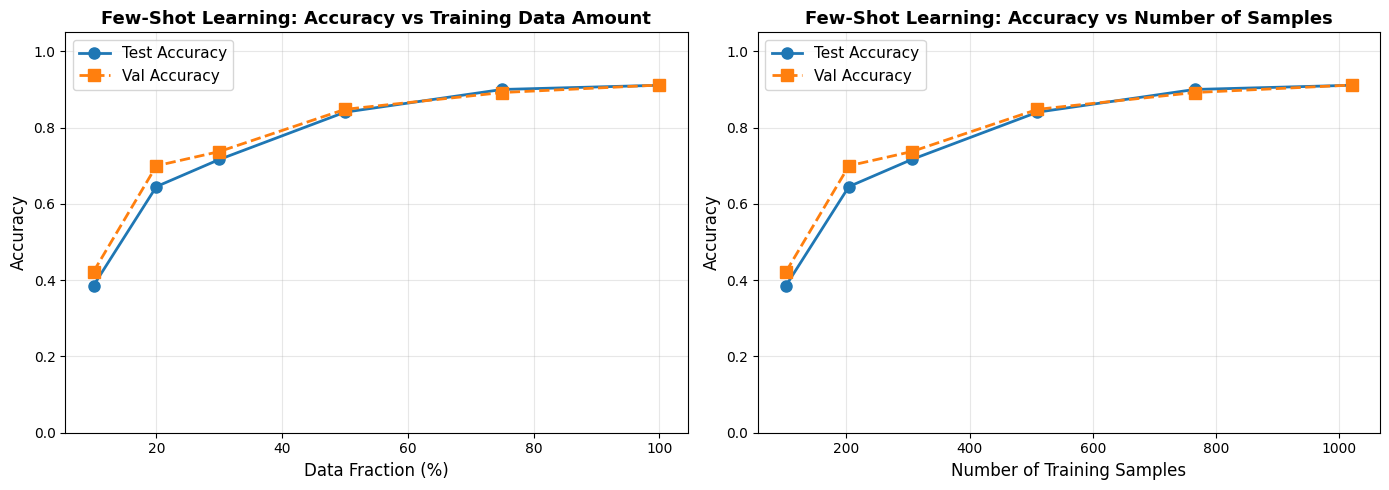


FEW-SHOT LEARNING RESULTS SUMMARY
    Data %    Samples      Val Acc     Test Acc  Improvement
----------------------------------------------------------------------
     10.0%        102       0.4225       0.3861        0.00%
     20.0%        204       0.7000       0.6455       67.19%
     30.0%        306       0.7373       0.7165       85.59%
     50.0%        510       0.8480       0.8406      117.73%
     75.0%        765       0.8922       0.9001      133.15%
    100.0%       1020       0.9118       0.9112      136.02%


In [ ]:
fractions = [r['data_fraction'] * 100 for r in few_shot_results]
test_accs = [r['test_acc'] for r in few_shot_results]
val_accs = [r['best_val_acc'] for r in few_shot_results]
num_samples = [r['num_samples'] for r in few_shot_results]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# acc vs data fraction
ax1.plot(fractions, test_accs, 'o-', linewidth=2, markersize=8, label='Test Accuracy')
ax1.plot(fractions, val_accs, 's--', linewidth=2, markersize=8, label='Val Accuracy')
ax1.set_xlabel('Data Fraction (%)', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Few-Shot Learning: Accuracy vs Training Data Amount', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11)
ax1.set_ylim([0, 1.05])

# acc vs no. of samples
ax2.plot(num_samples, test_accs, 'o-', linewidth=2, markersize=8, label='Test Accuracy')
ax2.plot(num_samples, val_accs, 's--', linewidth=2, markersize=8, label='Val Accuracy')
ax2.set_xlabel('Number of Training Samples', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Few-Shot Learning: Accuracy vs Number of Samples', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=11)
ax2.set_ylim([0, 1.05])

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("FEW-SHOT LEARNING RESULTS SUMMARY")
print("="*70)
print(f"{'Data %':>10} {'Samples':>10} {'Val Acc':>12} {'Test Acc':>12} {'Improvement':>12}")
print("-"*70)
baseline_test_acc = few_shot_results[-1]['test_acc']
for r in few_shot_results:
    improvement = (r['test_acc'] - few_shot_results[0]['test_acc']) / few_shot_results[0]['test_acc'] * 100
    print(f"{r['data_fraction']*100:>9.1f}% {r['num_samples']:>10d} {r['best_val_acc']:>12.4f} {r['test_acc']:>12.4f} {improvement:>11.2f}%")
print("="*70)